In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [6]:
segment_speeds = pd.read_csv("seg_data.csv")

In [7]:
segment_speeds = segment_speeds[48:]
segment_speeds.head(5)

,SegmentId,StartTime,EndTime,Speed
48,1071845897,6/22/2021 0:00,6/22/2021 0:30,93.566667
49,1071845897,6/22/2021 0:30,6/22/2021 1:00,93.400000
50,1071845897,6/22/2021 1:00,6/22/2021 1:30,101.000000
51,1071845897,6/22/2021 1:30,6/22/2021 2:00,93.766667
52,1071845897,6/22/2021 2:00,6/22/2021 2:30,101.000000


<AxesSubplot:>

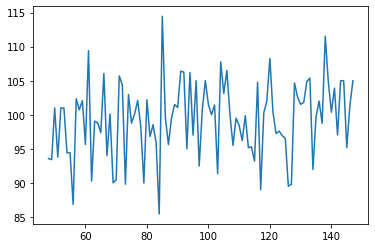

In [8]:
segment_speeds['Speed'][0:100].plot()

In [9]:
target_names = ['Speed']
shift_steps_of_30_min = 48
segment_speeds_targets = segment_speeds[['Speed']].shift(-shift_steps_of_30_min)
segment_speeds_targets.head(25)

,Speed
48,105.000000
49,92.466667
50,100.700000
51,105.000000
52,101.500000
53,100.000000
54,101.433333
55,91.333333
56,107.766667
57,103.133333


In [10]:
x_data = segment_speeds[['Speed']].values[0:-shift_steps_of_30_min]
x_data.shape
y_data = segment_speeds_targets.values[:-shift_steps_of_30_min]
y_data.shape

(9360, 1)

In [11]:
num_data = len(x_data)
num_data

9360

In [12]:
train_split = 0.9
num_train = int(train_split * num_data)
num_train

8424

In [13]:
num_test = num_data - num_train
num_test

936

In [14]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

9360

In [15]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

9360

In [16]:
num_x_signals = x_data.shape[1]
num_x_signals

1

In [17]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [18]:
print("Min:", np.min(segment_speeds['Speed']))
print("Max:", np.max(segment_speeds['Speed']))

Min: 15.66666667
Max: 134.3333333


In [19]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [20]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(8424, 1)
(8424, 1)


In [21]:

def batch_generator(batch_size, sequence_length):
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [22]:
batch_size = 64
sequence_length = 24 * 7 * 8
sequence_length

1344

In [23]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(64, 1344, 1)
(64, 1344, 1)


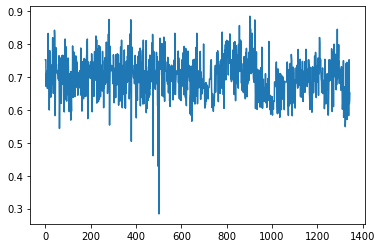

In [24]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [25]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [26]:
# Model
model = Sequential()
model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))
warmup_steps = 40


def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1052672   
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


C:\Users\vivs_\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [27]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir=".\\23_logs\\",
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [28]:
model.fit(x=generator,
          epochs=150,
          steps_per_epoch=120,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/150
120/120 [==============================] - 1467s 12s/step - loss: 0.0078 - val_loss: 0.0042

Epoch 00001: val_loss improved from inf to 0.00417, saving model to 23_checkpoint.keras
Epoch 2/150
120/120 [==============================] - 1618s 13s/step - loss: 0.0062 - val_loss: 0.0046

Epoch 00002: val_loss did not improve from 0.00417

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/150
120/120 [==============================] - 1710s 14s/step - loss: 0.0060 - val_loss: 0.0045

Epoch 00003: val_loss did not improve from 0.00417

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 4/150
120/120 [==============================] - 1795s 15s/step - loss: 0.0059 - val_loss: 0.0043

Epoch 00004: val_loss did not improve from 0.00417
Epoch 5/150
120/120 [==============================] - 1770s 15s/step - loss: 0.0059 - val_loss: 0.0043

Epoch 00005: val_loss did not improve from 0.00417
Epoch 6/150
120/120 [==============

In [35]:
model.fit(x=generator,
          epochs=120,
          steps_per_epoch=60,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/120
60/60 [==============================] - 817s 14s/step - loss: 0.0061 - val_loss: 0.0043

Epoch 00001: val_loss did not improve from 0.00417
Epoch 2/120
60/60 [==============================] - 782s 13s/step - loss: 0.0060 - val_loss: 0.0043

Epoch 00002: val_loss did not improve from 0.00417
Epoch 3/120
60/60 [==============================] - 797s 13s/step - loss: 0.0060 - val_loss: 0.0043

Epoch 00003: val_loss did not improve from 0.00417
Epoch 4/120
60/60 [==============================] - 818s 14s/step - loss: 0.0060 - val_loss: 0.0042

Epoch 00004: val_loss did not improve from 0.00417
Epoch 5/120
60/60 [==============================] - 784s 13s/step - loss: 0.0059 - val_loss: 0.0043

Epoch 00005: val_loss did not improve from 0.00417
Epoch 6/120
60/60 [==============================] - 757s 13s/step - loss: 0.0060 - val_loss: 0.0043

Epoch 00006: val_loss did not improve from 0.00417
Epoch 7/120
60/60 [==============================] - 751s 13s/step - loss: 0.0061 

In [30]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 154ms/step - loss: 0.0042


In [37]:
print("loss (test-set):", result)

loss (test-set): 0.0041701914742589


In [38]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()